In [1]:
import numpy as np
from dgamod import *
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import configparser
import sys
import os
import matplotlib.animation as animation
from drl_grams import *

mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

In [2]:
def state_fidelity(state):
    nh = np.shape(state)[0]
    fid = np.real(state[nh-1]*np.conjugate(state[nh-1]))
    return fid

In [3]:
def plot_single_sequence(action_sequence,nh,dt=0.15,b=100,label='',actions = 'original',add_natural=False):
    
    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence)+1
    # generar propagadores
    if actions == 'original':
        actions = actions_paper2(b, nh)
    elif actions == 'new':
        actions = new_actions(b,nh)
    elif actions == 'old':
        actions = actions_paper(b,nh)
    elif actions == 'four':
        actions = actions4(b,1,nh)
    elif actions == 'oaps':
        actions = one_field_actions(b,nh)
        
    propagators = gen_props(actions, nh, b, dt)
    times = np.arange(0,t_steps,1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    free_state = initial_state
    
    if add_natural:
        natural_evol = [state_fidelity(free_state)]
    
        nat_sequence = np.zeros(int(t_steps-1),dtype=int)

        for action in nat_sequence:
                
            free_state = calculate_next_state(free_state,0,propagators)
            natural_evol.append(state_fidelity(free_state))

        max_natural = np.max(natural_evol)

        plt.plot(times,natural_evol, '-v', label = 'Natural Evolution , Máx: {}'.format(max_natural))
    

    # inicializacion de estado forzado 
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    forced_evol = [state_fidelity(forced_state)]

    for action in action_sequence:
        
        forced_state = calculate_next_state(forced_state,action,propagators)
        forced_evol.append(state_fidelity(forced_state))

    max_forced = np.max(forced_evol)

    plt.plot(times,forced_evol,'-o', label = label + '. Máx.: {}'.format(max_forced))

    plt.legend(loc='upper left')
    #plt.show()


In [4]:
def find_max(action_sequences,nh, b=100, dt = 0.15, actions = 'original'):

    max_fid = 0.
    max_index = 0.

    if actions == 'original':
        actions = actions_paper2(b, nh)
    elif actions == 'new':
        actions = new_actions(b,nh)
    elif actions == 'old':
        actions = actions_paper(b,nh)
    elif actions == 'four':
        actions = actions4(b,1,nh)
    elif actions == 'oaps':
        actions = one_field_actions(b,nh)

    # generar propagadores
    propagators = gen_props(actions, nh, b, dt)

    for i in range(np.shape(action_sequences)[0]):
        action_sequence = action_sequences[i][:]
        action_sequence = [int(x) for x in action_sequence]

        t_steps = len(action_sequence)+1
        times = np.arange(0,t_steps,1)

        # definicion del estado inicial e inicializacion de estados forzado y natural

        initial_state = np.zeros(nh, dtype=np.complex_)
        initial_state[0] = 1.0        

        # inicializacion de estado forzado 
        forced_state = initial_state

        # almacenar evolucion natural y evolucion forzada
        forced_evol = [state_fidelity(forced_state)]

        for action in action_sequence:
            
            forced_state = calculate_next_state(forced_state,action,propagators)
            forced_evol.append(state_fidelity(forced_state))

            max_forced = np.max(forced_evol)
        
        if max_forced > max_fid:
            max_fid = max_forced
            max_index = i
    print('Max fid:',max_fid, 'Max Index:',max_index)
    return max_fid, max_index

In [5]:
n13_ga_loc_actions = uniformize_data('ga',**{'directory': 'resultados/n13stats_ga_lbv11/n13_stats_lbv11_1/', 'n':13})
n13_ga_acc_actions = uniformize_data('ga',**{'directory': 'resultados/n13stats_ga_acc/n13_stats_acc_1/', 'n':13})
n13_ga_oaps_actions = uniformize_data('ga',**{'directory': 'resultados/one_action_per_site/n13_one_action_per_site/', 'n':13})

for i in [2,3,4,5]:
    n13_ga_loc_actions = np.vstack((n13_ga_loc_actions, uniformize_data('ga',**{'directory': f'resultados/n13stats_ga_lbv11/n13_stats_lbv11_{i}/', 'n':13})))
    n13_ga_acc_actions = np.vstack((n13_ga_acc_actions, uniformize_data('ga',**{'directory': f'resultados/n13stats_ga_acc/n13_stats_acc_{i}/', 'n':13})))

n13_zhang_per_all = uniformize_data('zhang',**{'file': 'resultados/n13stats_per_16_acciones/experiment_0_n13_per_size120/success_action_sequences.dat'})
n13_zhang_per_best = uniformize_data('zhang',**{'file': 'resultados/n13stats_per_16_acciones/experiment_0_n13_per_size120/best_action_sequences.dat'})


for i in [1,2,3,4,5,6,7,8,9,10,11]:
    n13_zhang_per_all = np.vstack((n13_zhang_per_all, uniformize_data('zhang',**{'file' : f'resultados/n13stats_per_16_acciones/experiment_{i}_n13_per_size120/success_action_sequences.dat'})))
    n13_zhang_per_best = np.vstack((n13_zhang_per_best, uniformize_data('zhang',**{'file' : f'resultados/n13stats_per_16_acciones/experiment_{i}_n13_per_size120/best_action_sequences.dat'})))


find_max(n13_ga_loc_actions,13,actions='original')
find_max(n13_ga_acc_actions,13,actions='original')
find_max(n13_zhang_per_best,13,actions='original')
find_max(n13_ga_oaps_actions,13,actions='oaps')


Propagacion de autoestados: correcta
Max fid: 0.9884753244644158 Max Index: 377
Propagacion de autoestados: correcta
Max fid: 0.961666833309037 Max Index: 188
Propagacion de autoestados: correcta
Max fid: 0.9594811235731199 Max Index: 9
Propagacion de autoestados: correcta
Max fid: 0.9720765119472601 Max Index: 3


(0.9720765119472601, 3)

Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


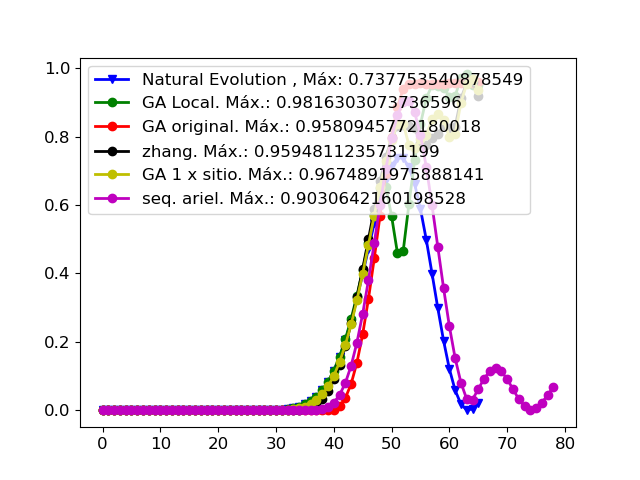

In [6]:
plt.figure()

plot_single_sequence(n13_ga_loc_actions[5][:],13,label='GA Local',actions='original',add_natural=True)
plot_single_sequence(n13_ga_acc_actions[100][:],13,label='GA original',actions='original',add_natural=False)

plot_single_sequence(n13_zhang_per_best[9][:],13,label='zhang',actions='original',add_natural=False)
plot_single_sequence(n13_ga_oaps_actions[1][:],13,label='GA 1 x sitio',actions='oaps',add_natural=False)


ariel = [14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 15, 15, 15, 15, 12, 12, 13, 2, 1, 11, 9, 13, 11, 5, 10, 4, 10, 1, 12, 13, 13, 13, 13, 6, 6, 6, 6, 6, 15, 15, 15, 15, 15, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 1, 1, 1, 10, 1, 15, 15, 15, 15, 15, 15, 6, 6, 6, 6, 1, 14, 13]

plot_single_sequence(ariel,13,label='seq. ariel',actions='original',add_natural=False)


Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


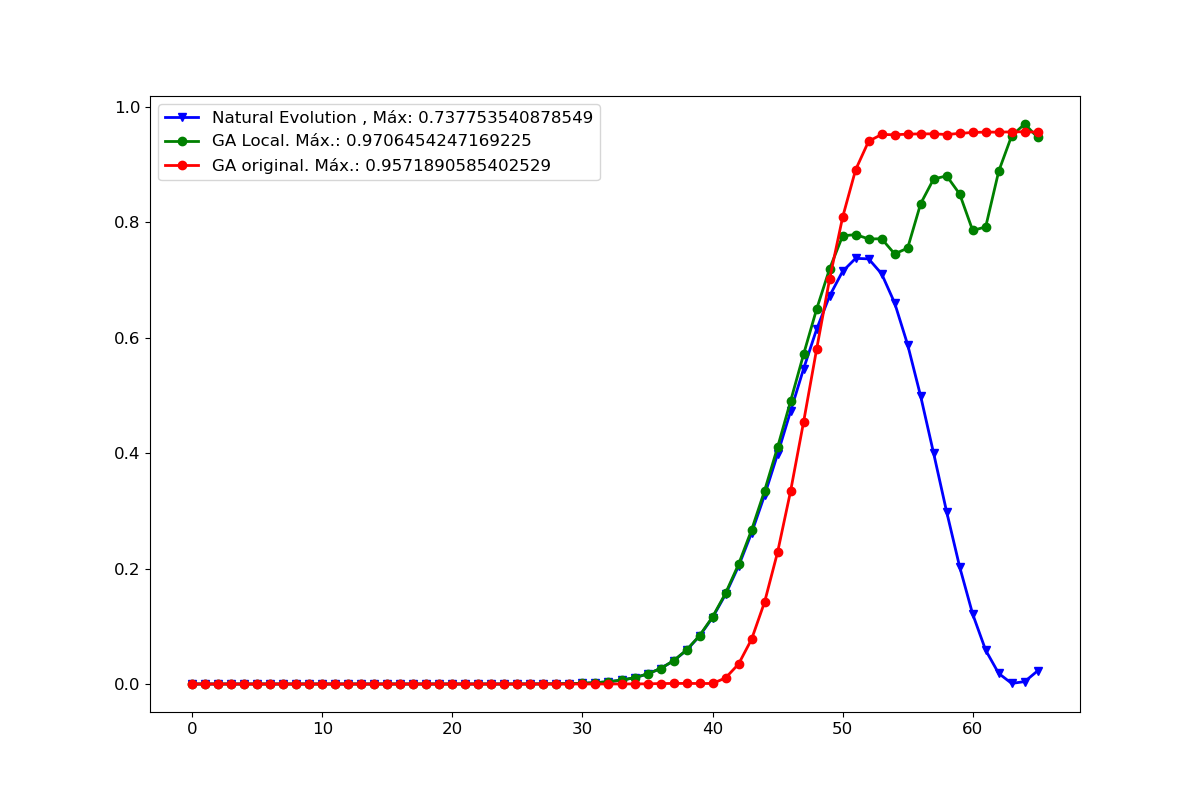

In [23]:
plt.figure(figsize=(12,8))

plot_single_sequence(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_natural=True)
plot_single_sequence(n13_ga_acc_actions[456][:],13,label='GA original',actions='original',add_natural=False)